# Development of driving accident numbers among young drivers with the introduction of BF17
# Final report

## Introduction
In the year 2011 the program BF17 ("Begleitetes Fahren ab 17" / "Accompanied Driving from 17 on") was introduced in Germany. 
Young people participating in this program can get their car driving license already at the age of 17, one year before the regular permission age, and can drive as long as they are accompanied by an adult.\
The benefit of this program was said to be a reduction of driving accidents because young drivers get more expertise together with an experienced companion.

Because now more than 10 years have passed since the introduction of BF17, it is interesting to take a look, if this hope of fewer accidents can be confirmed.
This is done in this project by looking at the number of driving accidents among young drivers in combination with the numbers of BF17 participants in the last years. 
First it is relevant to see how accepted this BF17 program is among young people, and if enough people are participating so that a meaningful influence on the accident numbers can be deduced.
The question then is if a correlation can be found in those two numbers: Has an increasing number of BF17 participants led to fewer driving accidents among young people?

In summary, the following questions should be answered in this project:
- Are enough young people using the BF17 program, so that a relevant influence in the accidents can be even deduced from the program?
- Did the introduction of BF17 reduce the number of accidents among young drivers?
- Could BF17 have any negative effect (for example an increase of accidents that already 17-year-olds have)?

## Methods and data pipeline
In general, the three questions should be answered by using open data and presenting them in suitable graphs so that an interpretation of the numbers is possible.  
No machine learning methods will be used in this project.

### Data sources
For this project two open data sources were chosen.

The first question is to be solved by checking the "Fahrerlaubnisse auf Probe" (driving permits on probation). 
That is the number of new class B (normal car) driving permits at the age of 17. 
These can only be obtained if BF17 is used, as the normal minimum age for class B without BF17 is 18.  
These numbers are offered as Excel files from the Kraftfahrbundesamt (KBA) for the years 2017 to 2023.

To answer the first question the driving permits of 17-year-olds are compared with the driving permits in general, to get gain the ratio of BF17 participants compared to non-participants among the years.
Also, the general development of new driving permits is checked.

Then the actual number of accidents is researched. 
The Statistisches Bundesamt offers the number of traffic accidents of all kinds in their Genesis Destatis data warehouse. 
This statistic contains all numbers of all age groups and all kinds of accidents so the needed numbers (especially accidents among young drivers but also the number of accidents in general) can be selected. 
Data is available from the years 2008 to 2023.

To answer the second and third question the number of accidents among younger people (age 17-25) as well the general accident trend is researched.
Also, the percentage change of accidents per year is calculated to check how the development of numbers has changed over the years and if a trend in certain age groups can be recognized.

For the number of driving accidents among different age groups over the last years only accidents with the following conditions are counted in this project:
- The respective person (to which age group the accident is accounted) was the main cause of the accident, not just a "participant"
- Only accidents caused by normal personal cars (Personenkraftwagen), LKWs (Güterkraftfahrzeuge), and agricultural vehicles (Landwirtschaftliche Zugmaschinen) are counted, as only these accidents could really be caused by young people, and could be influenced greatly by BF17. Especially accidents by busses are filtered out as bus licenses can only be caused by people of age 24 and older. Also, accidents caused by bikes and pedestrians are filtered out.
- All kinds of accidents are investigated here (accidents with only property damage, accidents with injured people...)
- All locations are considered (in cities, outside of cities, on highways...)
The filtering for these criteria is done by the data pipeline.

### The data pipeline
Because of the two different sources the pipeline consists of two smaller pipelines for both sources:
The kba_pipeline.py for the number of driving permits, and destatis_pipeline.py for the accident numbers. 
By running the main pipeline with pipeline.sh both pipelines are executed, and the data is collected to one single sqlite database.

The pipeline can be executed manually with the following steps:
- Create an account for the Genesis Destatis DWH => https://www-genesis.destatis.de/genesis/online
- Enter your username and password in the respective fields in the pipeline.sh
- Prepare a Python environment with the given project/requirements.txt (or run the pip install commands below)
- Execute the pipeline.sh (just ./project/pipeline.sh without parameters)
- The data of both pipelines is loaded into data/kba.sqlite 


The following pip packages are needed to run the pipeline and the result section:

In [1]:
%pip install numpy==1.24.2
%pip install packaging==23.0
%pip install pandas==1.5.3
%pip install pluggy==1.0.0
%pip install python-dateutil==2.8.2
%pip install SQLAlchemy==1.4.46
%pip install mechanize
%pip install openpyxl
%pip install requests
%pip install pytest
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Extraction, transformation and cleaning steps
The following steps are done for the both pipelines:

KBA pipeline:
The data does not exist in one single Excel file, but for each year an Excel file exists. So the following steps are done for each file:
- At first the data is extracted from the KBA website by just downloading the Excel file
- The needed table of the Excel file is extracted with the openpyxl library
- The data is transformed to a pandas dataframe for easier handling
- The data frame is cleaned and transformed by the following steps:
  - All missing numbers (designated in the Excel as - or .) are replaced with proper NaNs
  - The columns are renamed and their data type is changed correctly
  - The year is added as extra column
- Finally the table is appended to the sqlite file table 'Fahrerlaubnisse'

Destatis pipeline:
The data source Genesis is very hard to handle: It suffers from occasional outages and is in general very slow. Also, a free account has to created on the Genesis website. Because of this the pipeline has an offline mode which reuses a once downloaded file to transform. The online mode uses the genesis_puller.py file which has the logic to access Genesis.
The following steps are done in this pipeline:  
(Notice: If you use the pipeline.sh script then you don't use the command line params yourself, but enter the account data into the pipeline.sh, in which then the script is called properly with parameters!)
- If the destatis_pipeline.py is started with a Genesis account (Two command line params: Genesis user, Genesis password) => Online mode
  - Retrieve the data from the Genesis data warehouse by doing:
    - Send a batch request to Genesis with the needed table code so that the data is prepared on the Genesis server
    - each 15 seconds: check if the data preparation is done and pull the data if ready; else continue waiting
    - The data preparation can take up to several minutes
  - Write the pulled data into a csv (data/accidents.csv)
- If the destatis_pipeline.py is started without a Genesis account => Offline mode
  - Check if a pre downloaded data/accidents.csv exists
  - If yes: Continue with the transformation with this file
  - If no: Throw an error to the user; end of program
- The data is loaded from the downloaded/given csv as pandas dataframe
- Then the data is cleaned with the following steps:
  - Unnecessary header lines (because of the DWH format) are removed
  - The DWH slicing is done by removing unnecessary columns and rows (especially vehicle types which are not interesting for this project)
  - The columns are renamed and the data types are changed correctly
  - All missing numbers (designated as - or .) are replaced with proper NaNs
- Finally the dataframe is loaded into the sqlite database as own table

### Tests
To guarantee that the pipeline works also after code changes and is still doing the transformations correctly, a test suite was created.
The tests can be found in test_pipeline.py, it can be executed by running test_pipeline.sh.
The suite currently contains 7 tests which consist of system tests for both pipelines running all steps, but also extra tests for the single transformation and cleaning steps.
The online system test of the destatis_pipeline.py also runs the genesis_puller.py which is why the Genesis account data has to be entered in the test_pipeline.py (variables GENESIS_USER and GENESIS_PASSWORD) to run this test, else it is skipped. An offline system test also exists which is executed each time.

To test the single transformation and cleaning steps mock data is used which can be found under project/test_data. Although both data sources have licenses which allow the redistribution of data, the actual data of these tables is randomized/replaced by arbitrary numbers.

A CI/CD pipeline with GitHub Actions which executes the test suite after each commit to the repository was also set up. This pipeline is only set up with the offline Genesis pipeline, the online test with pulling from the Genesis DWH is skipped. The reason for this are, as already explained:
- The long execution time of the pipeline of up to several minutes
- And the occasional errors and outages of the Genesis database, which could lead to a failing CI/CD pipeline, although the pipeline is not at fault.

## Results
In the following section the results of the data analysis are presented. The interpretation and answering the main question are done in the next section "Interpretation".

### Preparing your environment
First prepare your environment and execute the data pipeline by doing the steps in the section **Methods and data pipeline** -> **The data pipeline**.

If all ran correctly, your data folder should contain a sqlite db file named **kba.sqlite**.

Now you can continue with the results of this project.

### Driving permits with BF17
At first, it is researched by how many young people the BF17 program is used.
For this the numbers of driving permits for the normal class B driving permission (PKWs) are investigated among the different age groups.

#### The main dataframe and filtering by the needed age groups

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

years = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]
ages = ["bis 17", "18", "19", "20", "21", "22", "23", "24", "25"]

permits_df = pd.read_sql_table('Fahrerlaubnisse', 'sqlite:///../data/kba.sqlite')

filtered = permits_df[permits_df["Alter"].isin(["bis 17", "18", "19", "20", "21", "22", "23", "24", "25"])]
filtered = filtered.sort_values(by=["Jahr"])

#### A plot diagram of driving permits over the last years

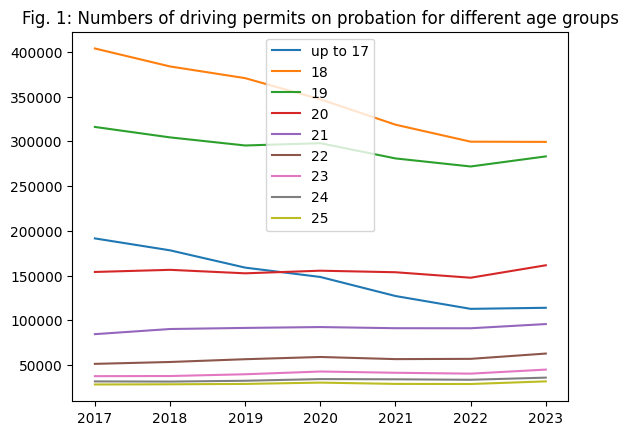

In [3]:
plt.figure()
plt.plot(years, (filtered[filtered["Alter"] == "bis 17"])["B"], label="up to 17")
plt.plot(years, (filtered[filtered["Alter"] == "18"])["B"], label="18")
plt.plot(years, (filtered[filtered["Alter"] == "19"])["B"], label="19")
plt.plot(years, (filtered[filtered["Alter"] == "20"])["B"], label="20")
plt.plot(years, (filtered[filtered["Alter"] == "21"])["B"], label="21")
plt.plot(years, (filtered[filtered["Alter"] == "22"])["B"], label="22")
plt.plot(years, (filtered[filtered["Alter"] == "23"])["B"], label="23")
plt.plot(years, (filtered[filtered["Alter"] == "24"])["B"], label="24")
plt.plot(years, (filtered[filtered["Alter"] == "25"])["B"], label="25")
plt.title("Fig. 1: Numbers of driving permits on probation for different age groups")
plt.legend()
plt.show()

This graph shows the number of new class B licenses (probation) from 2017 to 2023 among the different age groups from age 17 to 25.
Following observations can be done:
- The amount of new driving licenses is in general steadily sinking especially until 2022
- Most licenses in probation are by 18-year-olds. As the probation takes two years, this number consists of young people which did BF17 (and are now on the second year of their probation) AND people who gained their license only with 18 without BF17.
- Because the "up to 17" plot is especially in 2017 at about the half of the "18" plots, that directly shows, that about half of the 18-year-old new drivers have done BF17.
- In the last years the amount of BF17 is reduced a bit (shown by the decreasing "17" curve)
- From 21 years on there are only very few new driving licenses. Most people decide to do their class B license between 17 and 20.

#### The driving permits as bar diagram
The same data is now shown as bar diagram to better see the development of driving permits in general.

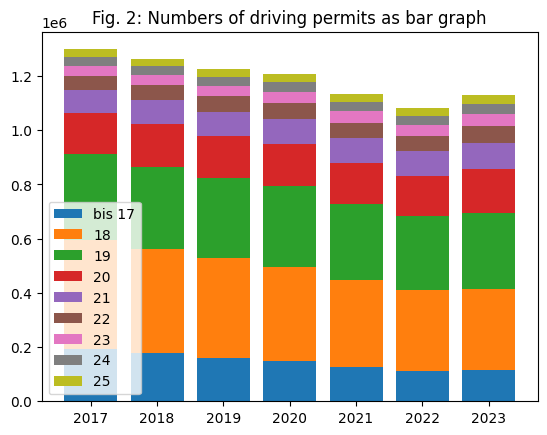

In [4]:
plt.figure()

sums = [0, 0, 0, 0, 0, 0, 0]
for i in range(0, len(ages)):
    values = (filtered[filtered["Alter"] == ages[i]])["B"]
    plt.bar(years, values, 
            bottom=sums, label=ages[i])
    sums = [x + y for x, y in zip(sums, values)]
    
plt.title("Fig. 2: Numbers of driving permits as bar graph")
plt.legend()
plt.show()

This bar graph shows the following facts:
- The general count of new driving licenses is sinking in recent years (except 2023)
- It is better visible that the group of 17-year-olds with driving license is steadily sinking while other age groups (especially 19 and 20) stay more constant (but also sinking)

#### The ratio of BF17 participants among 18-year-olds
Next the ratio of BF17 participants among 18-year-olds is calculated.

It should be noted that this ratio is always calculated by the 17-year-old and 18-year-olds of one year.
So the ratio is not calculated of people of the same age, but there is 1-year difference.

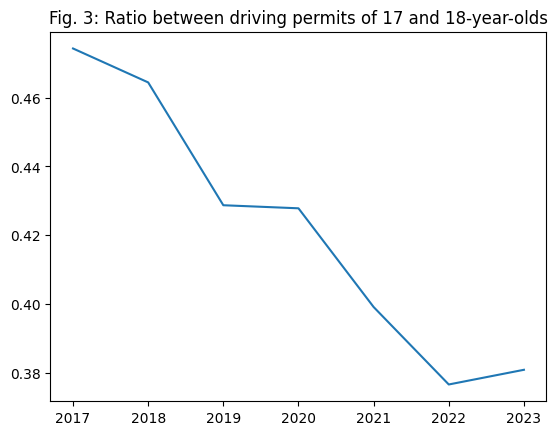

In [5]:
plt.figure()

data17 = (filtered[filtered["Alter"] == "bis 17"])["B"]
data18 = (filtered[filtered["Alter"] == "18"])["B"]
res = [i / j for i, j in zip(data17, data18)]

plt.plot(years, res)
plt.title("Fig. 3: Ratio between driving permits of 17 and 18-year-olds")
plt.show()

This graph proves the ratio between 17 and 18 year old driving permits is sinking but in general also has a high level.
In 2017 the ratio is at about 47%, while it sinks to about 38% in 2023.

### Driving accidents among young people
Next the amount of driving accidents over the last years among the different age groups is investigated.


#### The main data

In [6]:
import pandas as pd
import matplotlib as plt

accidents_df = pd.read_sql_table('accidents', 'sqlite:///../data/kba.sqlite')
accidents_df = accidents_df.fillna(0)
accidents_df = accidents_df.groupby("year").sum()

/var/folders/5b/6x75ry_x0571jsb9gmzl77yh0000gn/T/ipykernel_13229/3926792591.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  accidents_df = accidents_df.groupby("year").sum()


#### The number of accidents as plot diagram and as bar diagram

<Axes: title={'center': 'Fig. 4: Numbers of accidents in different age groups'}, xlabel='year'>

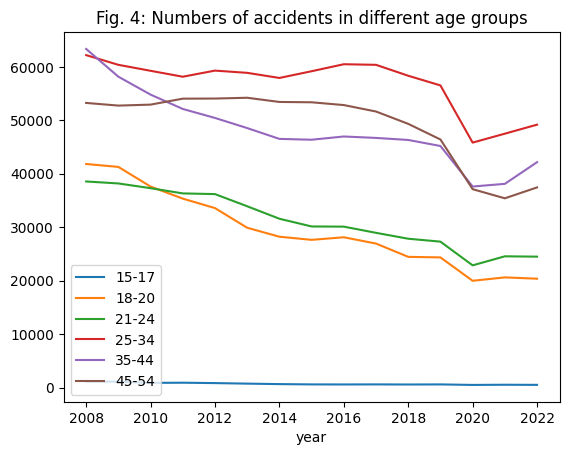

In [7]:
accidents_df.plot(title="Fig. 4: Numbers of accidents in different age groups")

<Axes: title={'center': 'Fig. 5: Numbers of accidents as bar graph'}, xlabel='year'>

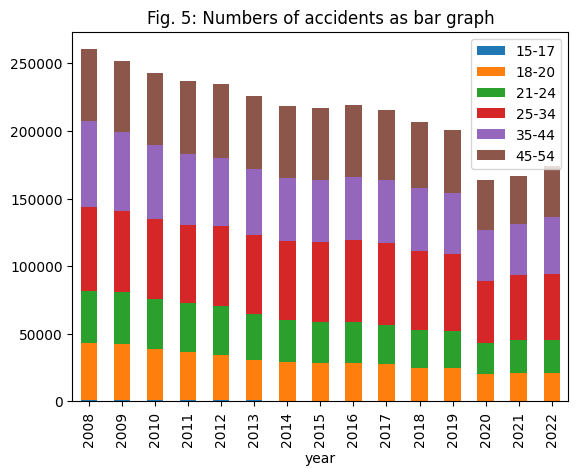

In [8]:
accidents_df.plot.bar(stacked=True, title="Fig. 5: Numbers of accidents as bar graph")

The following results can be deduced from both graphs:
- The number of accidents is in general sinking (especially visible in the bar diagram)
- The number of accidents by young people seem to be more rapidly sinking than those of other age groups, although this is a bit unclear here and is validated with another diagram.
- There are almost no accidents among 15-17 year old
- In general there are many accidents among young people up to 25 (visible by the fact that their areas are comparable big to the other age groups - but older age groups have spans of 10 years, the 21-24 only 4 years, and 18-20 even only 3 years)

To check if the statement about the more rapid sinking of accidents among young people is true, the percentage change of accident numbers each year are shown in the following graph:

<Axes: title={'center': 'Fig. 6: Change of accidents per year over different age groups'}, xlabel='year'>

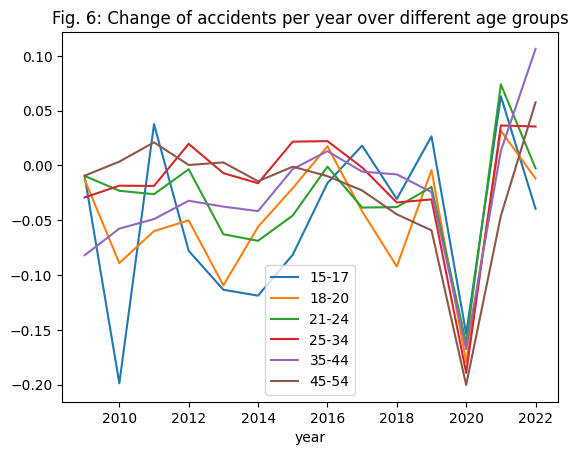

In [9]:
change = accidents_df[['15-17', '18-20', '21-24', '25-34', '35-44', '45-54']].pct_change()
change.plot(title="Fig. 6: Change of accidents per year over different age groups")

In general the groups 15-17, 18-20 and 21-24 belong to the groups with the largest negative percentage change of accidents, although there are some exceptions in some years:
- for 18-20 this is for example 2016, where they had the second-greatest change, although it went rapidly down in the both years after
- for 15-17 the changes were among the highest from 2017-2019. 

One especially interesting data point is the change from 2009 to 2010 for 15-17. There was a change of -20% visible which is very extreme, and may be labeled an outlier.

In [10]:
accidents_df

,15-17,18-20,21-24,25-34,35-44,45-54
year,,,,,,
2008,1138,41829,38563,62189,63347,53250
2009,1127,41287,38194,60374,58157,52751
2010,903,37610,37310,59257,54804,52933
2011,937,35357,36331,58149,52122,54047
2012,864,33586,36203,59292,50443,54069
2013,766,29910,33929,58874,48547,54216
2014,675,28235,31596,57918,46524,53432
2015,620,27648,30152,59175,46369,53370
2016,610,28130,30118,60485,46973,52849


If the numbers of accidents are directly observed, a reason for the outlier and the general unsteady development of accident numbers among 15-17 year olds can be found:

They can be explained by the fact that in this age group only very few relevant accidents happen - less than 1000 per year, when in the next age group there are already more than at least 20000 - more than 20-fold.

Even a small change in accident numbers among 15-17 causes a huge percentage change. So the percentage numbers in this age group should be treated with caution.

## Interpretation
In the following the three initial question should be answered by the found observations.



### Are enough young people using the BF17 program, so that a relevant influence in the accidents can be even deduced from the program?
The main problem of this question is that there only exists data for the years from 2017 on, and no data from 2008-2016 where accident data would be available.

But it could be shown that the BF17 is at least from 2017 on strongly accepted. 
As observed in Fig. 1 and Fig. 3 in 2017 about half of the 18-year-old drivers have also done BF17.
Therefore, one could deduce that also in the years before many young drivers also have done BF17, as it is unlikely that this number rose from 0 to 50% from one year to the next one.
The ratio for this program is very big.

In recent years however this ratio seems to sink a bit again which comes especially clear in Fig. 3. The ratio sank from 47% to 38% which means that fewer young people use the BF17 program. 
Instead, more young people do their driving license at the of 18 or over.
It might be interesting to keep an eye on this development in the next years.
Currently, the ratio is still rather high, but if the negative trend stays like this, BF17 might lose its relevance.

Especially in Fig. 2 it could be observed that general number of new driving permits among young people is sinking.
The reason for this cannot be determined by the data, but it remains an interesting open question.


### Did the introduction of BF17 reduce the number of accidents among young drivers?
### Could BF17 have any negative effect (for example an increase of accidents that already 17-year-olds have)?
These questions are harder to answer with the available data.
In general in Fig. 4 and Fig. 5 it can be seen that the overall accident numbers of all age groups is sinking in the last few years even before COVID.
Also, as seen in Fig. 6, the number of accidents among younger drivers is sinking stronger than those of other age groups in most of the last years.
On the other hand there are also outliers, but in general it could be assumed that the introduction of BF17 actually reduced the number of accidents among young drivers.

But the main problem here is that the accident database only gives data from 2008 on.
BF17 was completely introduced as federal law in 2011, but years before that the states could autonomously introduce BF17, so that most states already had a BF17 program in 2008.
To answer this question more securely it would be very useful to have data before 2008, so that accident numbers without any BF17 program anywhere in Germany could be analyzed.

Because of this and the general sinking accident numbers it is very hard to deduce a BF17 effect, i.e. a positive effect on the accident numbers which can be only accounted to BF17, from the accident numbers. 
The more drastic percentage change among young drivers might be a hint to a positive effect by BF17 but without more data from more years this cannot be said for sure.
Therefore, the second question remains unanswered.

But on the other hand the third question can be answered as "no" with a high probability.
For this question to be answered positively, an increase of accident numbers among young drivers (or at least a higher percentage change) should be recognizable some years after 2008 when the program was more broadly accepted in the public.
But this can be denied.
As already explained, the change rates are often more negatively than those of older drivers, or at least comply to the overall development in some years.
But the accident numbers do not behave completely different from the other ones.

A relationship between the accident numbers and the number of BF17 participants cannot be deduced from this data especially because there only exist few data points from 2018 on and also the COVID pandemic heavily skews the statistic. 
But although the BF17 participant numbers are sinking, a clear trend in the accident cannot be determined.

## Final remarks and outlook
In the end the three main question can only be answered to a certain degree while many details remain unclear.
The chosen datasets did not prove as useful as hoped in the beginning of the project, especially because it became clear that the data of both sources covered too few years to make more meaningful comparisons and get clearer results.
Also, it became clear that the whole topic is more complicated as assumed.
There are many reasons for the changes in accident numbers, especially technical innovations in cars but also maybe new concepts in educating driving students.
Because of this, this field remains open for more research.

Also, other related questions have arisen, which may also help to answer the question of the BF17 influence.
Especially interesting is the question, why in general all accident numbers go down among all age groups and also the number of new driving permits, and if both trends are related.
The answers to these questions may help to get more hints about the real effect of BF17.

The positive message of this project is, that BF17, although the full effects of the program could not really be measured, is widely accepted by young drivers in Germany, and does not seem to have bad effects on the driving skills or accidents numbers of young drivers, but at least an indifferent, but very more likely, a positive effect.  
Therefore, it can be deemed a success.